## Quick Look: File structure and content

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib import pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings("ignore")



Bad key "text.kerning_factor" on line 4 in
C:\Users\Mac\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
folder = 'm5-forecasting-uncertainty/'
calendar = pd.read_csv(folder+'calendar.csv')
price = pd.read_csv(folder+'sell_prices.csv')
validation = pd.read_csv(folder+'sales_train_validation.csv')

In [3]:
d_cols = [col for col in validation.columns if col.startswith('d_')]
cc = validation[d_cols].stack().reset_index(level=1)
cc.columns = ['d','sales']
cc['day_int'] = cc.d.apply(lambda day:day.split('_')[1]).astype('int')
cc.sales = cc.sales.astype('int')
validation = validation.drop(d_cols, axis=1).join(cc)

In [4]:
price.store_id = price.store_id.astype('category')
price.item_id = price.item_id.astype('category')
price.wm_yr_wk = pd.to_numeric(price.wm_yr_wk, downcast='unsigned')
price.sell_price = pd.to_numeric(price.sell_price, downcast='float')
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    uint16  
 3   sell_price  float32 
dtypes: category(2), float32(1), uint16(1)
memory usage: 58.8 MB


In [5]:
calendar = calendar.fillna('NotEvent')

calendar.date = calendar.date.astype('datetime64')

calendar.wm_yr_wk = pd.to_numeric(calendar.wm_yr_wk, downcast='unsigned')
calendar.weekday = calendar.weekday.astype('category')
calendar.wday = pd.to_numeric(calendar.wday, downcast='unsigned')
calendar.month = pd.to_numeric(calendar.month, downcast='unsigned')
calendar.year = pd.to_numeric(calendar.year, downcast='unsigned')
calendar.d = calendar.d.astype('category')

calendar.event_name_1 = calendar.event_name_1.astype('category')
calendar.event_type_1 = calendar.event_type_1.astype('category')
calendar.event_name_2 = calendar.event_name_2.astype('category')
calendar.event_type_2 = calendar.event_type_2.astype('category')

calendar.snap_CA = calendar.snap_CA.astype('bool')
calendar.snap_TX = calendar.snap_TX.astype('bool')
calendar.snap_WI = calendar.snap_WI.astype('bool')

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   uint16        
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   uint8         
 4   month         1969 non-null   uint8         
 5   year          1969 non-null   uint16        
 6   d             1969 non-null   category      
 7   event_name_1  1969 non-null   category      
 8   event_type_1  1969 non-null   category      
 9   event_name_2  1969 non-null   category      
 10  event_type_2  1969 non-null   category      
 11  snap_CA       1969 non-null   bool          
 12  snap_TX       1969 non-null   bool          
 13  snap_WI       1969 non-null   bool          
dtypes: bool(3), category(6), datetime64[ns](1), uint16(2), uint8(2)
memory usage: 144.0 KB


In [6]:
validation.id = validation.id.astype('category')
validation.item_id = validation.item_id.astype('category')
validation.dept_id = validation.dept_id.astype('category')
validation.cat_id = validation.cat_id.astype('category')
validation.store_id = validation.store_id.astype('category')
validation.state_id = validation.state_id.astype('category')
validation.d = validation.d.astype('category')

validation.sales = pd.to_numeric(validation.sales, downcast='unsigned')
validation.day_int = pd.to_numeric(validation.day_int, downcast='unsigned')

validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 30489
Data columns (total 9 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        category
 1   item_id   category
 2   dept_id   category
 3   cat_id    category
 4   store_id  category
 5   state_id  category
 6   d         category
 7   sales     uint16  
 8   day_int   uint16  
dtypes: category(7), uint16(2)
memory usage: 1.2 GB


In [7]:
validation = validation.merge(calendar, on='d', how='left').merge(price, on=['store_id','item_id','wm_yr_wk'], how='left')
del calendar, price
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 23 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sales         uint16        
 8   day_int       uint16        
 9   date          datetime64[ns]
 10  wm_yr_wk      uint16        
 11  weekday       category      
 12  wday          uint8         
 13  month         uint8         
 14  year          uint16        
 15  event_name_1  category      
 16  event_type_1  category      
 17  event_name_2  category      
 18  event_type_2  category      
 19  snap_CA       bool          
 20  snap_TX       bool          
 21  snap_WI       bool          
 22  sell_price    float32       
dtypes: bool(3), category(11), date

In [46]:
meta_df = pd.DataFrame({})

meta_df = meta_df.append([['item_id','id for item','categorical','product','high','']])
meta_df = meta_df.append([['dept_id','id for item dept','categorical','product','middle','']])
meta_df = meta_df.append([['cat_id','id for item category','categorical','product','middle','']])
meta_df = meta_df.append([['sell_price','sell price for item','numerical','product','middle','']])

meta_df = meta_df.append([['store_id','id for store','categorical','store','middle','']])
meta_df = meta_df.append([['state_id','id for state','categorical','store','middle','']])

meta_df = meta_df.append([['weekday','day of week','categorical','context','low','']])
meta_df = meta_df.append([['wday','day of week in number','categorical','context','middle','']])
meta_df = meta_df.append([['month','month','categorical','context','middle','']])
meta_df = meta_df.append([['year','year','categorical','context','low','']])

meta_df.columns = ['name','desc','type','segment','expectation','conclusion']
meta_df.sort_values(by='expectation')

,name,desc,type,segment,expectation,conclusion
0,item_id,id for item,categorical,product,high,
0,weekday,day of week,categorical,context,low,
0,year,year,categorical,context,low,
0,dept_id,id for item dept,categorical,product,middle,
0,cat_id,id for item category,categorical,product,middle,
0,sell_price,sell price for item,numerical,product,middle,
0,store_id,id for store,categorical,store,middle,
0,state_id,id for state,categorical,store,middle,
0,wday,day of week in number,categorical,context,middle,
0,month,month,categorical,context,middle,


## For subjective analysis, choose item_id,sell_price,month,wday,state_id as features for training

## From the target - sales

In [8]:
validation.sales.describe()

count    5.832737e+07
mean     1.126322e+00
std      3.873108e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: sales, dtype: float64

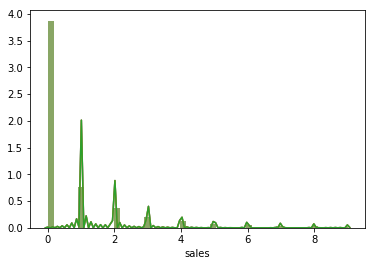

In [12]:
sns.distplot(validation.query('sales < 10').sales)
plt.show()

In [10]:
print("Skewness: %f" % validation.sales.skew())
print("Kurtosis: %f" % validation.sales.kurt())

Skewness: 17.212285
Kurtosis: 873.404303


## Relation between top 5 and sales

### Numerical in top 5¶

In [14]:
import random

In [17]:
plt.subplots(figsize=(25, 15))


var = 'sell_price'

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,1)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])


item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,2)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,3)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,4)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,5)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,6)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,7)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,8)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

item_rand = random.choice(validation.item_id.unique().tolist())
ax = plt.subplot(3,3,9)
ax.set_title(item_rand)
ax.set_xlabel('sell price')
ax.set_ylabel('sales')
tmp = validation.query('item_id == "'+item_rand+'"')
data = pd.concat([tmp.sales, tmp[var]], axis=1)
plt.scatter(x=data[var], y=data['sales'])

### Categorical in top 5

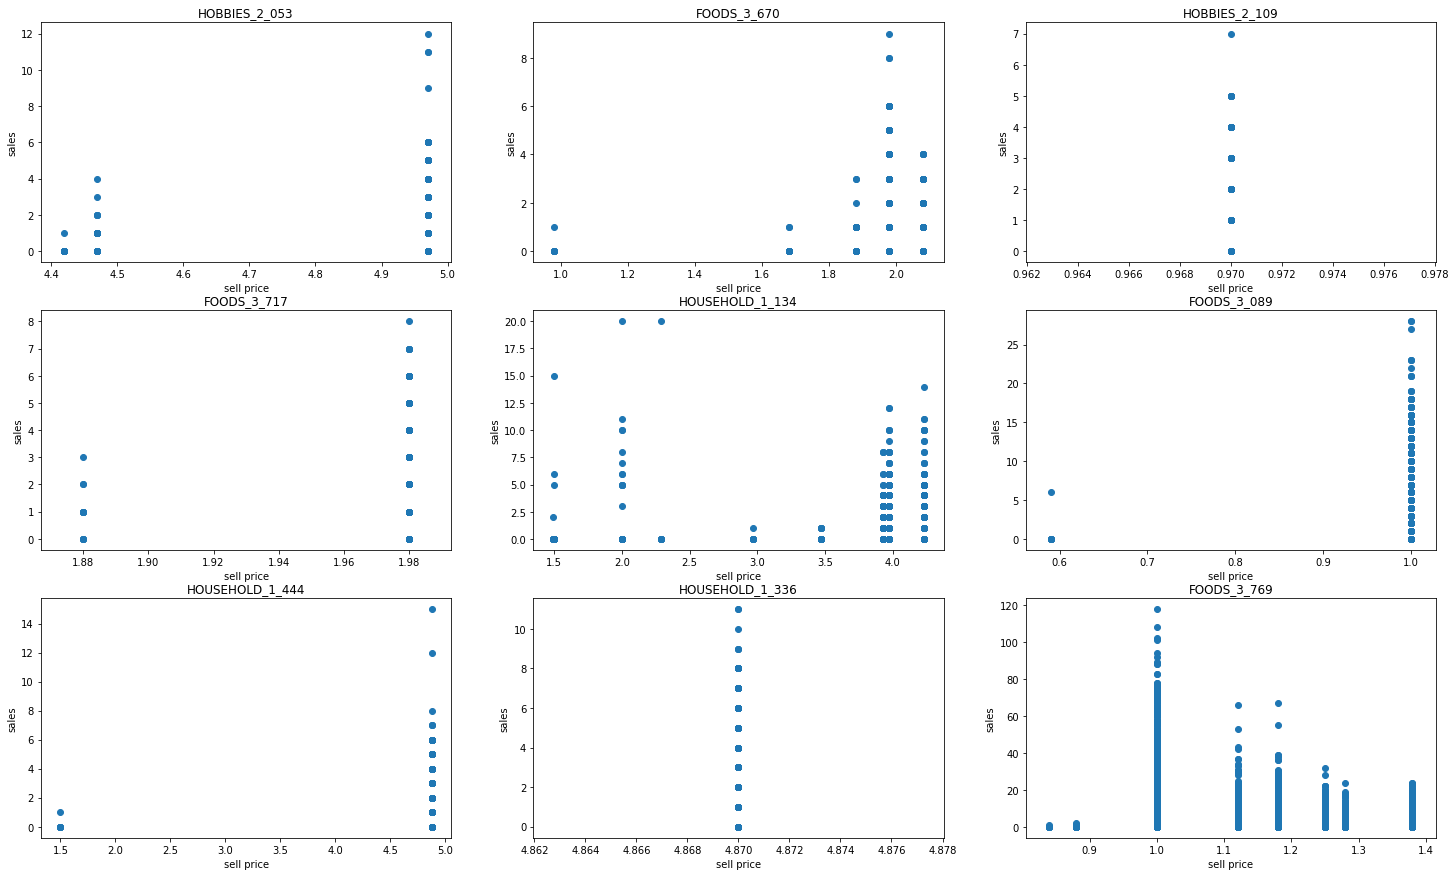

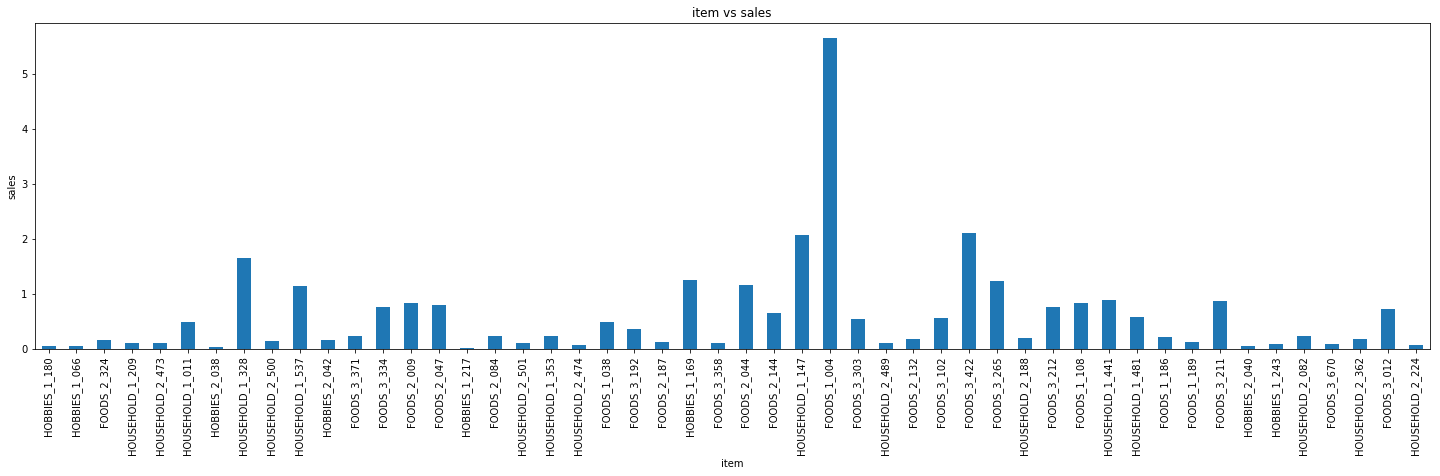

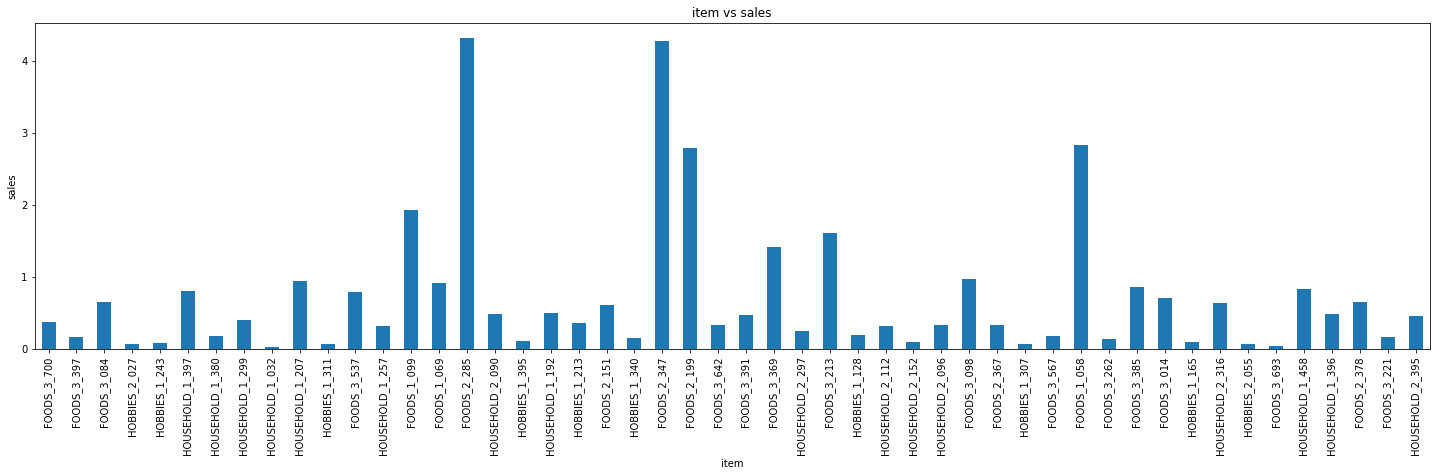

In [19]:
store_rand = random.choice(validation.store_id.unique().tolist())
tmp = validation.query('store_id == "'+store_rand+'"')
f, ax = plt.subplots(figsize=(25, 6))
tmp.groupby('item_id').mean()['sales'].sample(50).plot(kind='bar')
ax.set_title('item vs sales')
ax.set_xlabel('item')
ax.set_ylabel('sales')
plt.show()

In [20]:
store_rand = random.choice(validation.store_id.unique().tolist())
tmp = validation.query('store_id == "'+store_rand+'"')
f, ax = plt.subplots(figsize=(25, 6))
tmp.groupby('month').mean()['sales'].plot(kind='bar')
ax.set_title('month vs sales')
ax.set_xlabel('month')
ax.set_ylabel('sales')

Text(0,0.5,'sales')

In [21]:
store_rand = random.choice(validation.store_id.unique().tolist())
tmp = validation.query('store_id == "'+store_rand+'"')
f, ax = plt.subplots(figsize=(25, 6))
tmp.groupby('weekday').mean()['sales'].plot(kind='bar')
ax.set_title('weekday vs sales')
ax.set_xlabel('weekday')
ax.set_ylabel('sales')

Text(0,0.5,'sales')

In [22]:
tmp = validation.sample(100000)
f, ax = plt.subplots(figsize=(12, 6))
tmp.groupby('state_id').mean()['sales'].plot(kind='bar')
ax.set_title('state vs sales')
ax.set_xlabel('state')
ax.set_ylabel('sales')

Text(0,0.5,'sales')

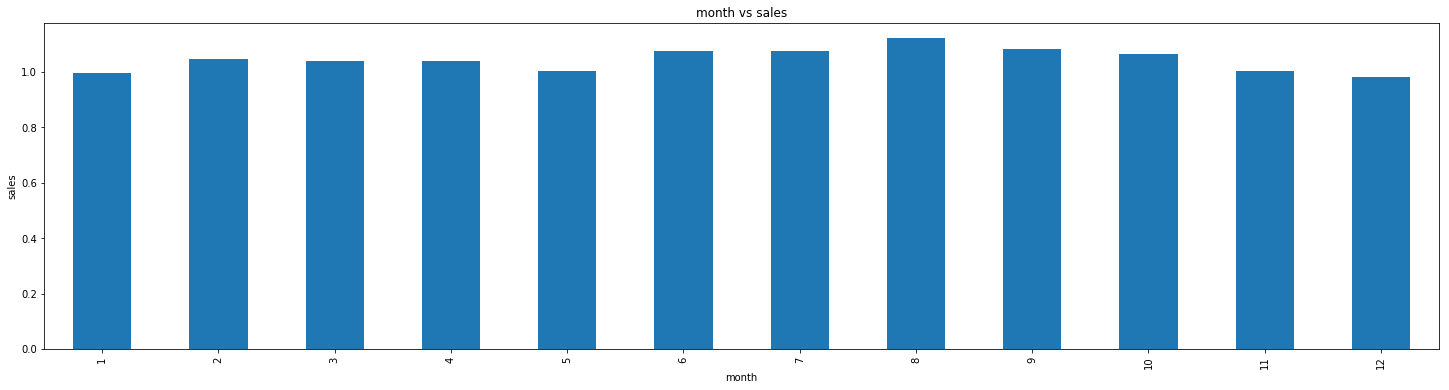

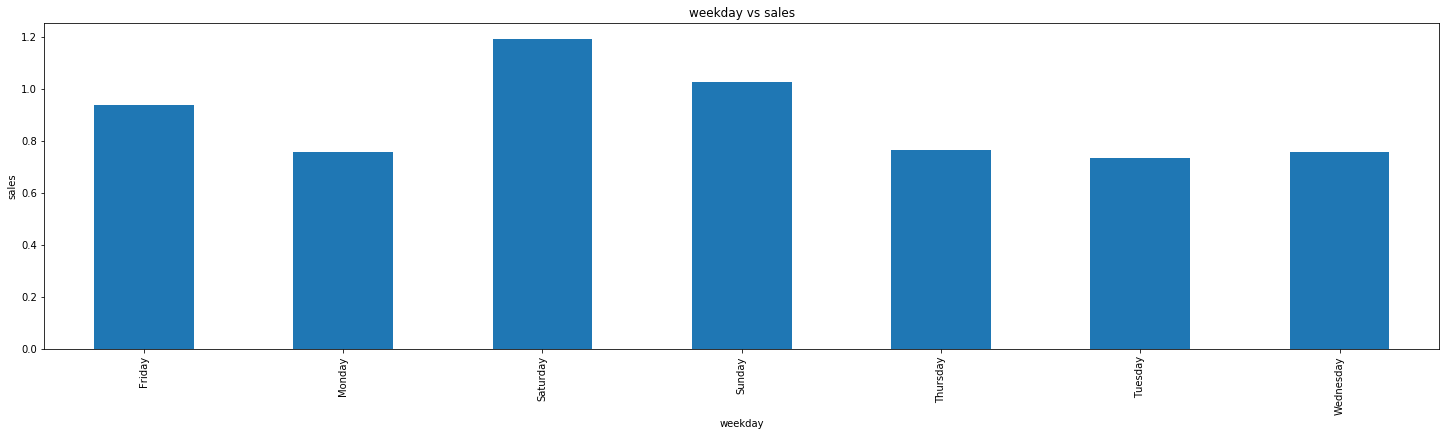

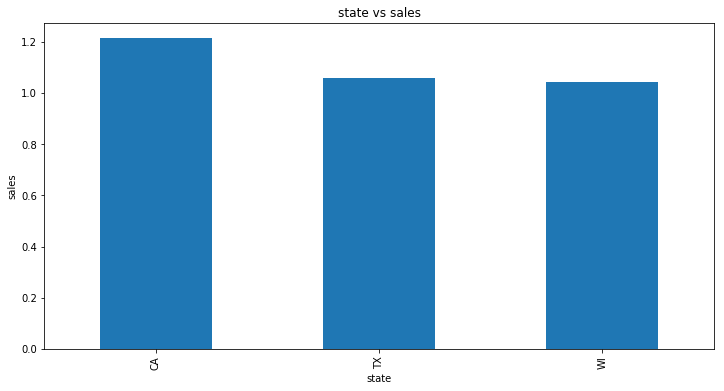

In [24]:
plt.show()

### Objective Analysis

In [25]:
for col in validation.columns:
    if str(validation[col].dtype) == 'category':
        validation[col] = validation[col].cat.codes

validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 23 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int16         
 1   item_id       int16         
 2   dept_id       int8          
 3   cat_id        int8          
 4   store_id      int8          
 5   state_id      int8          
 6   d             object        
 7   sales         uint16        
 8   day_int       uint16        
 9   date          datetime64[ns]
 10  wm_yr_wk      uint16        
 11  weekday       int8          
 12  wday          uint8         
 13  month         uint8         
 14  year          uint16        
 15  event_name_1  int8          
 16  event_type_1  int8          
 17  event_name_2  int8          
 18  event_type_2  int8          
 19  snap_CA       bool          
 20  snap_TX       bool          
 21  snap_WI       bool          
 22  sell_price    float32       
dtypes: bool(3), datetime64[ns](1),

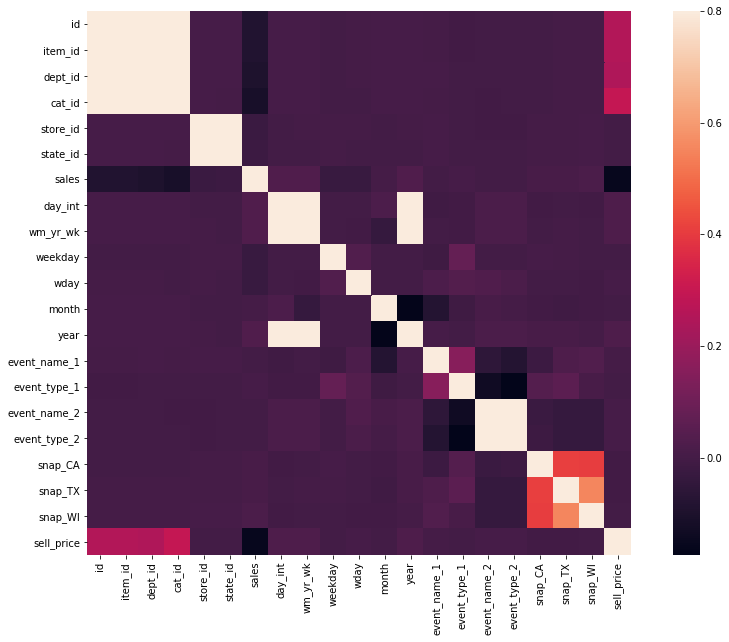

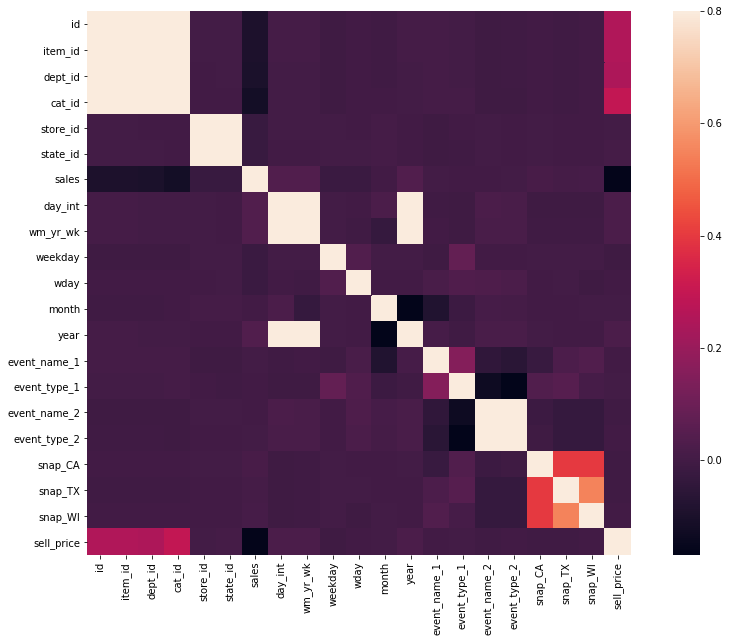

In [34]:
corrmat = validation.sample(100000).corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [35]:
print('Top 5:', corrmat.nlargest(5, 'sales')['sales'].index.tolist())

Top 5: ['sales', 'wm_yr_wk', 'day_int', 'year', 'snap_CA']


## Dig from time-series

In [36]:
sample = validation.query('store_id==0 and item_id==0')[['date','sales']]
sample = sample.set_index('date')

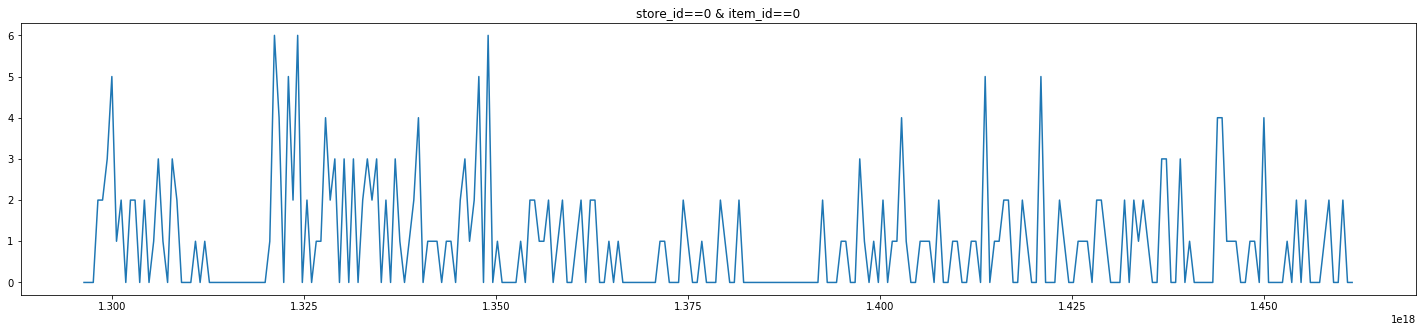

In [37]:
plt.subplots(figsize=(25, 5))
plt.plot(sample.asfreq('w').index, sample.asfreq('w').values)
plt.title('store_id==0 & item_id==0')
plt.show()

### Shift and lag

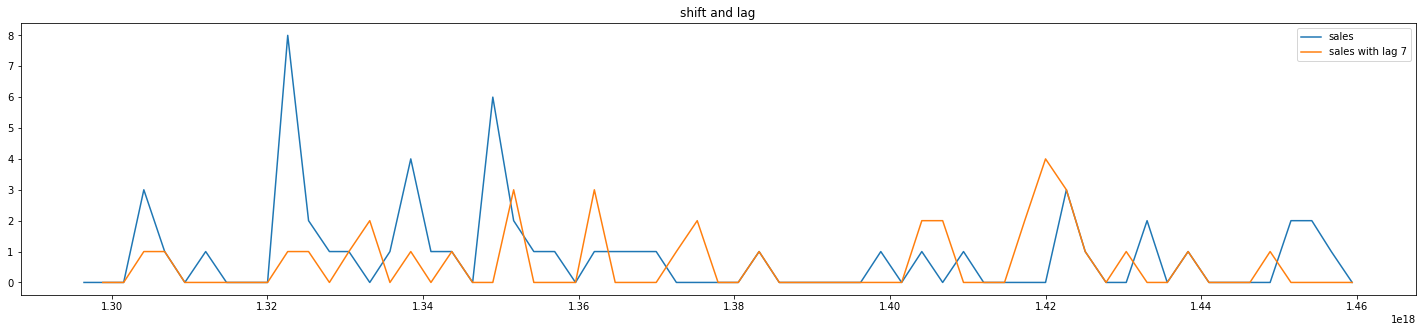

In [38]:
plt.subplots(figsize=(25, 5))
plt.plot(sample.asfreq('M').index, sample.asfreq('M').values)
plt.plot(sample.asfreq('M').shift(7).index, sample.shift(7).asfreq('M').values)
plt.legend(['sales','sales with lag 7'])
plt.title('shift and lag')
plt.show()

### Change

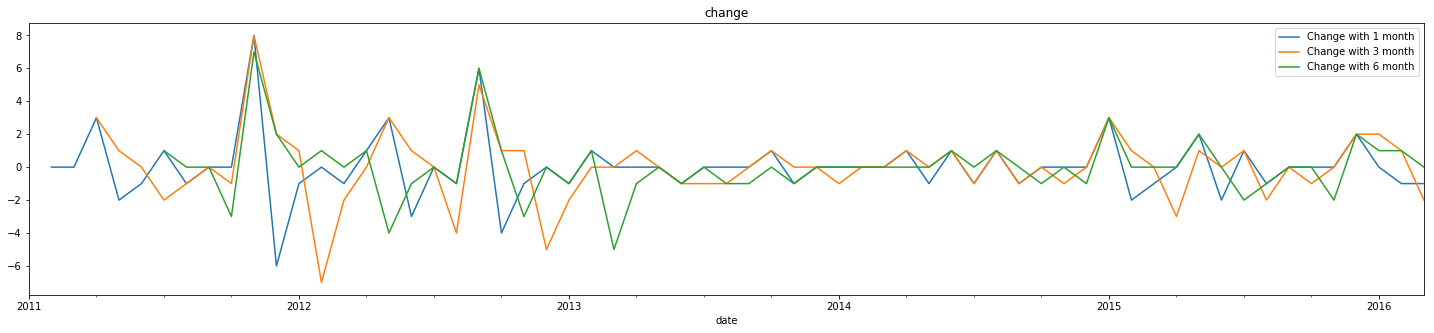

In [39]:
plt.subplots(figsize=(25, 5))
(sample.asfreq('M').sales - sample.asfreq('M').sales.shift()).plot()
(sample.asfreq('M').sales - sample.asfreq('M').sales.shift(3)).plot()
(sample.asfreq('M').sales - sample.asfreq('M').sales.shift(6)).plot()
plt.legend(['Change with 1 month','Change with 3 month','Change with 6 month'])
plt.title('change')
plt.show()

### Rolling window

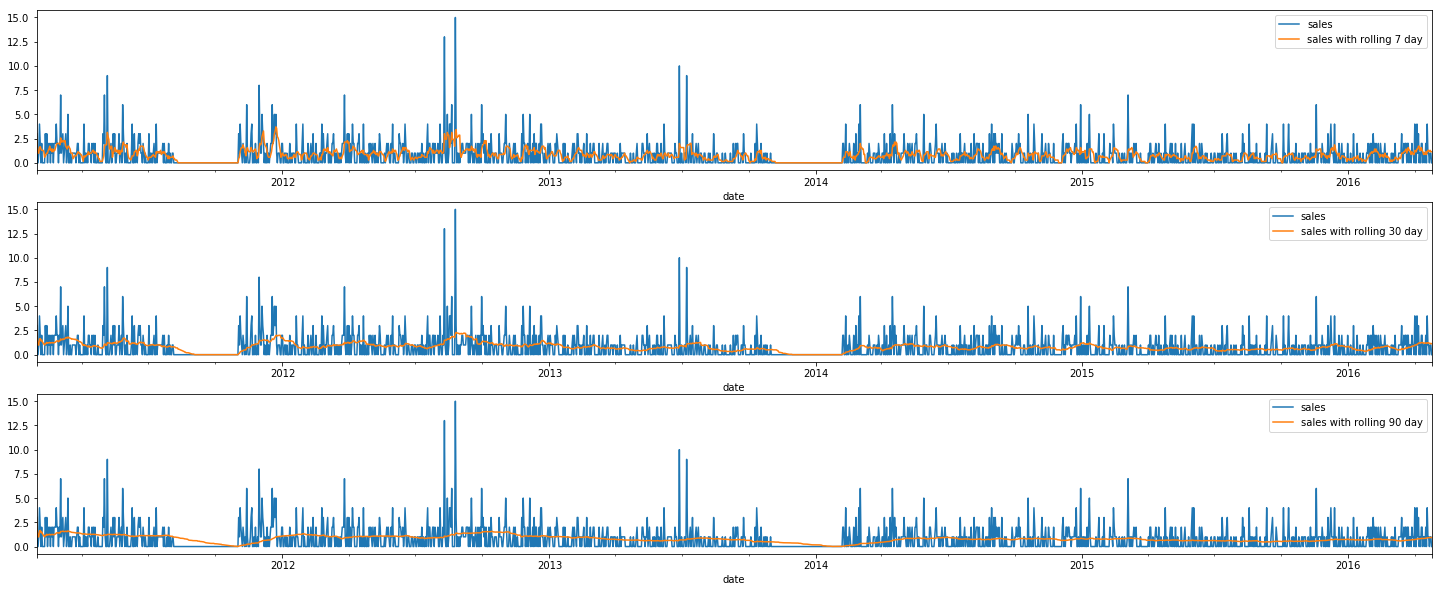

In [40]:
plt.subplots(figsize=(25, 10))
plt.title('rolling window')

ax = plt.subplot(3,1,1)
rolling_sample = sample.sales.rolling('7D').mean()
sample.sales.plot()
rolling_sample.plot()
plt.legend(['sales','sales with rolling 7 day'])

ax = plt.subplot(3,1,2)
rolling_sample = sample.sales.rolling('30D').mean()
sample.sales.plot()
rolling_sample.plot()
plt.legend(['sales','sales with rolling 30 day'])

ax = plt.subplot(3,1,3)
rolling_sample = sample.sales.rolling('90D').mean()
sample.sales.plot()
rolling_sample.plot()
plt.legend(['sales','sales with rolling 90 day'])
plt.show()

### Autocorrelation

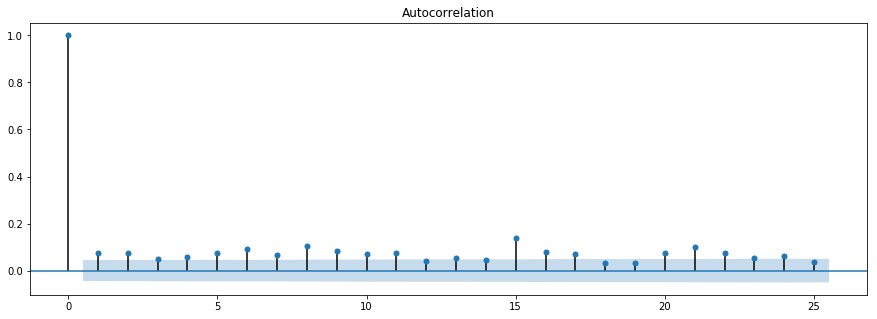

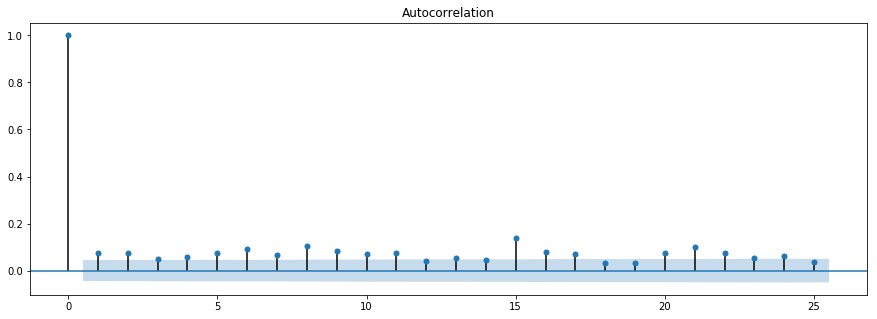

In [42]:
plt.subplots(figsize=(15, 5))
ax = plt.subplot(1,1,1)
plot_acf(sample.sales,lags=25,title="Autocorrelation", ax=ax).show()
plt.show()

### Partial Autocorrelation

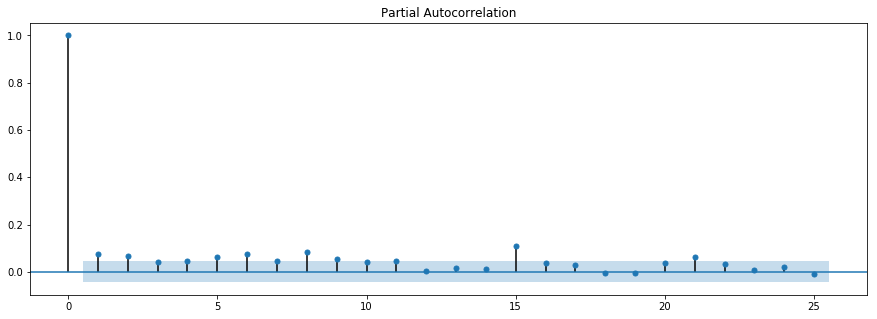

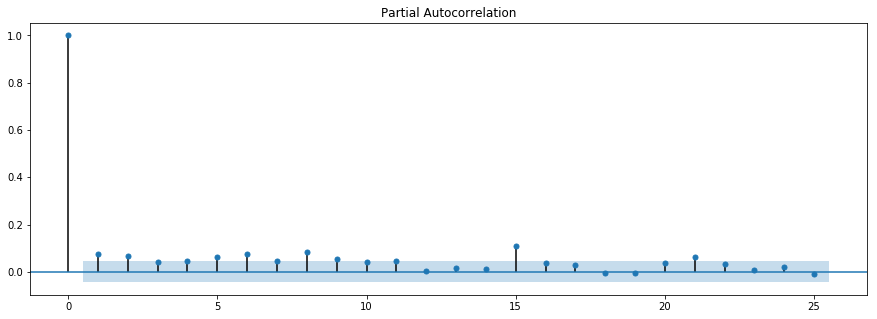

In [44]:
plt.subplots(figsize=(15, 5))
ax = plt.subplot(1,1,1)
plot_pacf(sample.sales,lags=25,title="Partial Autocorrelation", ax=ax).show()
plt.show()